<a href="https://colab.research.google.com/github/AbeHandler/AbeHandler.github.io/blob/master/EricSaeedDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import json
import enum

with open('data.jsonl', 'r') as f:
  lines = f.readlines()
  lines = [o.strip("\n").replace('"', "'").replace("'", '"').strip('"') for o in lines]

data = [json.loads(line) for line in lines]
df = pd.DataFrame(data)
df = df[df["number"].apply(lambda x: len(x) > 0)]

participants = df.groupby("guidString").count().reset_index()[["guidString", "turn"]]

ids = participants[participants["turn"] > 175]["guidString"].to_list()
ids

['0f9eddbc-54a7-4be3-b581-60475c09f961',
 '1478084c-c08c-4295-be9a-1665da41b2f0',
 '354d7416-7fe6-4924-99fb-c3c0a36737b1',
 '4416d72c-5d11-40c4-9d1c-6fcf8d8a4533',
 'efbabaa4-7895-4d32-b844-757a8877716a']

In [60]:
import pandas as pd
import json
import enum
import math

id2clevelandanalysis = {}

with open('data.jsonl', 'r') as f:
    lines = f.readlines()
    lines = [o.strip("\n").replace('"', "'").replace("'", '"').strip('"') for o in lines]
    data = [json.loads(line) for line in lines]


df = pd.DataFrame(data)
df = df[df["number"].apply(lambda x: len(x) > 0)]

print(len(df))
df = df[df["guidString"].apply(lambda x: x in ids)]
print(len(df))

df["CamZ"] = df["CamZ"].apply(lambda x: round(float(x)))
df["CamZ"] = df["CamZ"].apply(lambda x: -5 if x <= -5 else x) # if more neg then -5, just clip to -5
df["CamZ"] = df["CamZ"].apply(lambda x: 5 if x >= 5 else x) # if more pos then +5, just clip to +5

assert len(df["CamZ"].apply(lambda x: math.floor(float(x))).unique()) == 3

class Position(enum.Enum):
    RIGHT = 5
    CENTER =  0
    LEFT = -5

df["position"] = df["CamZ"].apply(lambda x: Position(round(float(x))).name)

df["number"] = df["number"].apply(lambda x: float(x))
df["Lvar"] = df["Lvar"].apply(lambda x: float(x))
df["Rvar"] = df["Rvar"].apply(lambda x: float(x))
df["Cleveland"] = df.index > 90
df["larger"] = df[["Lvar", "Rvar"]].max(axis=1)
df["smaller"] = df[["Lvar", "Rvar"]].min(axis=1)
df["data_pct"] = (df["smaller"] / df["larger"]) * 100
df = df.drop("larger", axis=1)
df = df.drop("smaller", axis=1)


# cleveland analysis
dfC = df[df["Cleveland"]].copy()
dfC["bias"] = dfC["number"] - dfC["data_pct"]
dfC['right_bigger'] = (dfC['Rvar'] > dfC['Lvar'])
dfC['sideSmall'] = (dfC['right_bigger'] & (dfC['position'] == 'LEFT')) | (~dfC['right_bigger'] & (dfC['position'] == 'RIGHT'))
dfC = dfC[dfC["position"] != "CENTER"]
dfC = dfC.groupby('sideSmall').agg({'bias': ['mean', 'std']}).reset_index()

dfnC = df[~df["Cleveland"]].copy()
dfnC["number"] = dfnC["number"].apply(lambda x: int(x))
dfnC['Lvar'] = dfnC['Lvar'].apply(lambda x: x * 100)
dfnC["ncbias"] = dfnC["number"] - dfnC['Lvar']
dfnC["error"] = dfnC["number"] - dfnC['Lvar']
dfnC["error"] = dfnC["error"].abs()
dfnC = dfnC.groupby('position')['error'].mean()


930
901


In [66]:
dfC = df[df["Cleveland"]].copy()
dfC["bias"] = dfC["number"] - dfC["data_pct"]
dfC['right_bigger'] = (dfC['Rvar'] > dfC['Lvar'])
dfC['sideSmall'] = (dfC['right_bigger'] & (dfC['position'] == 'LEFT')) | (~dfC['right_bigger'] & (dfC['position'] == 'RIGHT'))
dfC = dfC[dfC["position"] != "CENTER"]
dfC.groupby(['sideSmall', "guidString"]).agg({'bias': ['mean', 'std']}).reset_index().sort_values("guidString")

sideSmall                            guidString       bias           
                                                        mean        std
0     False  0f9eddbc-54a7-4be3-b581-60475c09f961  -9.223131  15.630907
5      True  0f9eddbc-54a7-4be3-b581-60475c09f961  12.068306   6.818085
1     False  1478084c-c08c-4295-be9a-1665da41b2f0 -19.080356  24.110888
6      True  1478084c-c08c-4295-be9a-1665da41b2f0 -11.965030  33.168945
2     False  354d7416-7fe6-4924-99fb-c3c0a36737b1 -13.931187  26.117566
7      True  354d7416-7fe6-4924-99fb-c3c0a36737b1 -10.808264  26.631576
3     False  4416d72c-5d11-40c4-9d1c-6fcf8d8a4533 -31.310675  26.653765
8      True  4416d72c-5d11-40c4-9d1c-6fcf8d8a4533 -28.186322  25.854722
4     False  efbabaa4-7895-4d32-b844-757a8877716a -22.072443  25.101286
9      True  efbabaa4-7895-4d32-b844-757a8877716a  -4.911000  28.555855

<Axes: xlabel='position', ylabel='ncbias'>

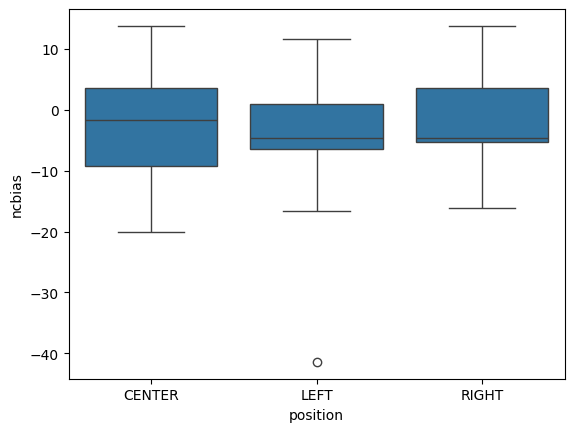

In [ ]:
# prompt: make box plot with seaborne of dfnC error by position

import seaborn as sns

sns.boxplot(x="position", y="ncbias", data=dfnC)


'{"CamX": "-0.3272639", "CamY": "0.8589801", "CamZ": "-0.6473732", "ClevelandMode": "False", "Lvar": "0.2610157", "Rvar": "0.2610157", "UnixTime": "1713480848", "dataset": "-1", "guidString": "8d796c02-e1e9-4553-a434-a1b913601f2b", "number": "27", "turn": "0"}'

In [ ]:
df["CamZ"].apply(lambda x: round(float(x))).unique().max()

5